<a href="https://colab.research.google.com/github/ASWANTH-J/av_loan_prediction_hackathon/blob/main/walmart_sales_prediction_1.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('walmart-sales-prediction')
jovian.set_colab_id('1J5Z7YTCoGH0bdhXVMaOcpFoQ1zMZr_mW')

     |████████████████████████████████| 68 kB 2.7 MB/s 


# walmart-sales-prediction

This project is based on the kaggle competition Walmart Recruiting - Store Sales Forecasting

Competition link : https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

Aim : To predict the weekly sales of the different walmart stores

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import jovian

In [4]:

# Execute this to save new versions of the notebook
jovian.commit(project="walmart-sales-prediction")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aswanthjeje28/walmart-sales-prediction


'https://jovian.ai/aswanthjeje28/walmart-sales-prediction'

# Importing Libraries,Classes,Methods

In [5]:
!pip install opendatasets

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import opendatasets as od

import os
from os import walk
from zipfile import ZipFile

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [9]:
od.download("https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data")

Skipping, found downloaded files in "./walmart-recruiting-store-sales-forecasting" (use force=True to force download)


#Loading datasets

In [10]:
dir='./walmart-recruiting-store-sales-forecasting'
os.chdir(dir)

In [11]:
for (root,dirs,files) in walk('.'):
    for file in files :
        if file.endswith('.zip'):
            with ZipFile(file) as f:
                f.extractall()

In [12]:
train_df = pd.read_csv('train.csv',parse_dates=True)
test_df = pd.read_csv('test.csv',parse_dates=True)
features_df = pd.read_csv('features.csv',parse_dates=True)
stores_df = pd.read_csv('stores.csv',parse_dates=True)
ss = pd.read_csv('sampleSubmission.csv')

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [14]:
# Execute this to save new versions of the notebook
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aswanthjeje28/walmart-sales-prediction


'https://jovian.ai/aswanthjeje28/walmart-sales-prediction'

# Data Preparation before analysis

In [15]:
merge_train_df = pd.merge(train_df,features_df,how="inner",on=["Store","Date"])
merge_train_df = pd.merge(merge_train_df,stores_df,how="inner",on=["Store"])

In [16]:
merge_test_df = pd.merge(test_df,features_df,how="inner",on=["Store","Date"])
merge_test_df = pd.merge(merge_test_df,stores_df,how="inner",on=["Store"])

In [17]:
full_df = pd.concat([merge_train_df,merge_test_df],axis=0).reset_index(drop=True)

## spliting date into day,month,year

In [18]:
full_df['Date'] = pd.to_datetime(full_df['Date'])
full_df['Day'] = full_df.Date.dt.day
full_df['Month'] = full_df.Date.dt.month
full_df['Year'] = full_df.Date.dt.year

In [19]:
merge_train_df = full_df[:train_df.shape[0]]
merge_test_df =  full_df[train_df.shape[0]:]

#Exploratory Data Analysis

##Brief overview of the datasets

In [20]:
print(f"\nTrain set has {train_df.shape[0]} rows and {train_df.shape[1]} columns")
print(f"\nTest set has {test_df.shape[0]} rows and {test_df.shape[1]} columns")


Train set has 421570 rows and 5 columns

Test set has 115064 rows and 4 columns


In [21]:
full_df.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size,Day,Month,Year
536629,45,93,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,B,118221,26,7,2013
536630,45,94,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,B,118221,26,7,2013
536631,45,95,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,B,118221,26,7,2013
536632,45,97,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,B,118221,26,7,2013
536633,45,98,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,B,118221,26,7,2013


In [22]:
#target column
target = 'Weekly_Sales'
#primary features
p_features = [col for col in merge_train_df.columns if col != target]

### Missing values

In [23]:
merge_train_df[p_features].isnull().sum()/merge_train_df.shape[0]*100

Store            0.000000
Dept             0.000000
Date             0.000000
IsHoliday_x      0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       64.257181
MarkDown2       73.611025
MarkDown3       67.480845
MarkDown4       67.984676
MarkDown5       64.079038
CPI              0.000000
Unemployment     0.000000
IsHoliday_y      0.000000
Type             0.000000
Size             0.000000
Day              0.000000
Month            0.000000
Year             0.000000
dtype: float64

In [24]:
merge_test_df[p_features].isnull().sum()/merge_test_df.shape[0]*100

Store            0.000000
Dept             0.000000
Date             0.000000
IsHoliday_x      0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1        0.129493
MarkDown2       24.879198
MarkDown3        8.542203
MarkDown4       11.200723
MarkDown5        0.000000
CPI             33.165890
Unemployment    33.165890
IsHoliday_y      0.000000
Type             0.000000
Size             0.000000
Day              0.000000
Month            0.000000
Year             0.000000
dtype: float64

In [25]:
full_df[p_features].isnull().sum()/full_df.shape[0]*100

Store            0.000000
Dept             0.000000
Date             0.000000
IsHoliday_x      0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       50.507049
MarkDown2       63.162043
MarkDown3       54.843338
MarkDown4       55.809173
MarkDown5       50.339337
CPI              7.111365
Unemployment     7.111365
IsHoliday_y      0.000000
Type             0.000000
Size             0.000000
Day              0.000000
Month            0.000000
Year             0.000000
dtype: float64

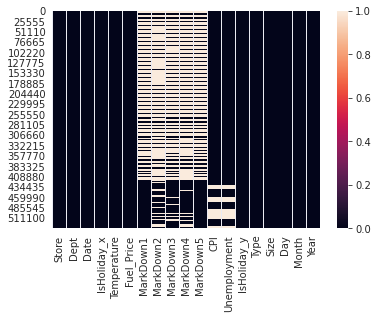

In [26]:
sns.heatmap(full_df[p_features].isnull())

## Analysing each features

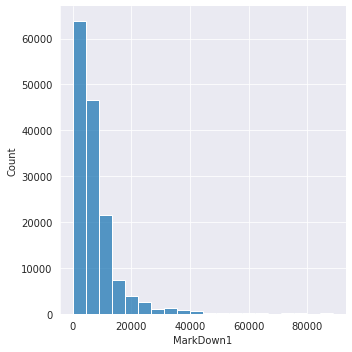

In [27]:
sns.displot(x='MarkDown1',data=merge_train_df,bins=20)

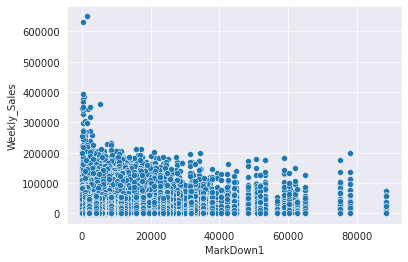

In [28]:
sns.scatterplot(x='MarkDown1',y='Weekly_Sales',data=merge_train_df)

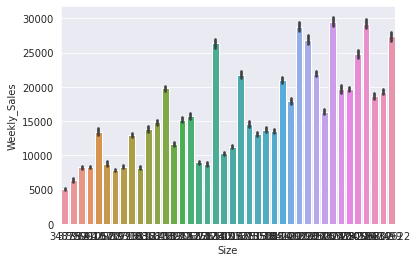

In [29]:
sns.barplot(x='Size',y=target,data=merge_train_df)

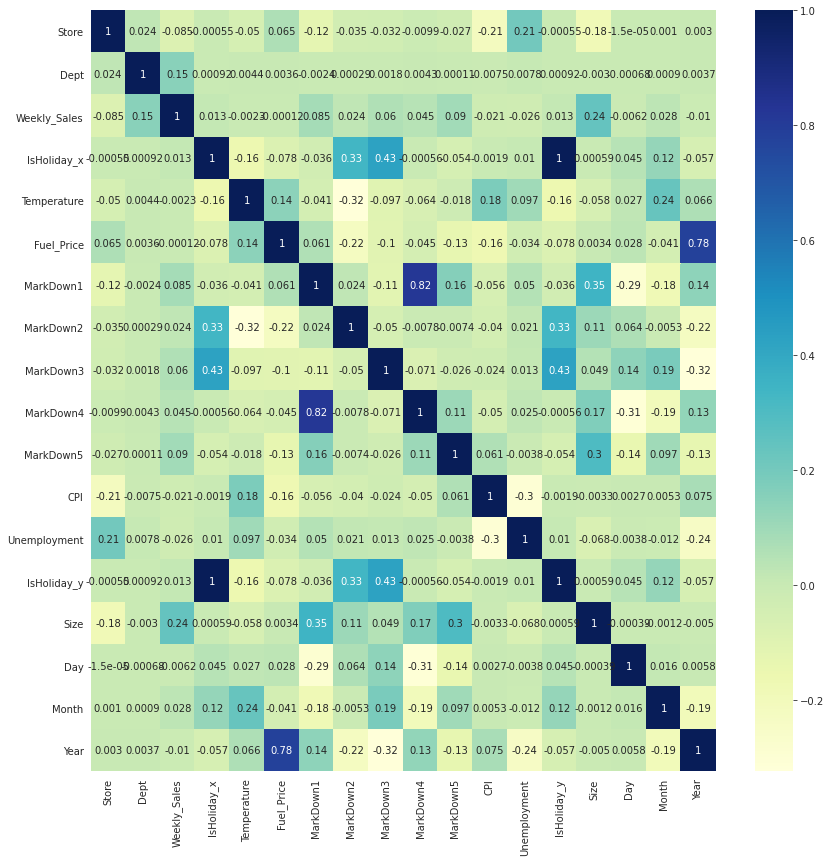

In [30]:
plt.figure(figsize=(14,14))
sns.heatmap(merge_train_df.corr(),annot=True,cmap='YlGnBu')

Average sales on holiday week and normal week


In [53]:
merge_train_df

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size,Day,Month,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,2,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,26,10,2012
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,26,10,2012
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,26,10,2012
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,26,10,2012


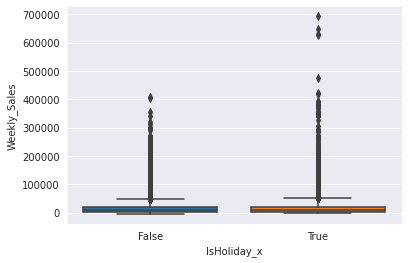

In [66]:
sns.boxplot(x='IsHoliday_x',y=target,data=merge_train_df)

In [84]:
merge_train_df.query('Store ==4 and Dept==13')[['Temperature','CPI','Weekly_Sales']].corr()

,Temperature,CPI,Weekly_Sales
Temperature,1.000000,0.164328,0.105034
CPI,0.164328,1.000000,0.567060
Weekly_Sales,0.105034,0.567060,1.000000


In [71]:
merge_train_df.query('Store ==1 and Dept==1 and IsHoliday_x==False').head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size,Day,Month,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,2,2010
145,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315,19,2,2010
218,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315,26,2,2010
290,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315,5,3,2010
363,1,1,2010-03-12,21043.39,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False,A,151315,12,3,2010


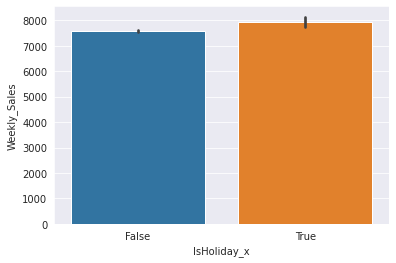

In [68]:
sns.barplot(x='IsHoliday_x',y=target,data=merge_train_df,estimator=np.median)

# Data Preparation

## Missing value imputation

Half of the Values in markdown columns are not available so it's better to remove the markdown columns from the training data 

In [31]:
full_df = pd.concat([merge_train_df,merge_test_df],axis=0)
full_df.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],axis=1,inplace=True)
full_df.drop(['IsHoliday_y','Date'],axis=1,inplace=True)
full_df.rename({'IsHoliday_x':'IsHoliday'},axis=1,inplace=True)

### CPI

In [32]:
def rmse(y_true,y_pred):
  return mean_squared_error(y_true,y_pred,squared=False)

In [33]:
features= ['Store','Fuel_Price','Day','Month','Year','Temperature']

In [34]:
X = full_df[~full_df.CPI.isnull()][features]
y = full_df[~full_df.CPI.isnull()].CPI
X_test = full_df[full_df.CPI.isnull()][features]
y_test = full_df[full_df.CPI.isnull()].CPI
model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X_test)
full_df.loc[full_df.CPI.isnull(),'CPI'] = y_pred

### Unemployment

In [35]:
X = full_df[~full_df.Unemployment.isnull()][features]
y = full_df[~full_df.Unemployment.isnull()].Unemployment
X_test = full_df[full_df.Unemployment.isnull()][features]
y_test = full_df[full_df.Unemployment.isnull()].Unemployment
model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X_test)
full_df.loc[full_df.Unemployment.isnull(),'Unemployment'] = y_pred

In [36]:
full_df

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Day,Month,Year
0,1,1,24924.50,False,42.31,2.572,211.096358,8.106000,A,151315,5,2,2010
1,1,2,50605.27,False,42.31,2.572,211.096358,8.106000,A,151315,5,2,2010
2,1,3,13740.12,False,42.31,2.572,211.096358,8.106000,A,151315,5,2,2010
3,1,4,39954.04,False,42.31,2.572,211.096358,8.106000,A,151315,5,2,2010
4,1,5,32229.38,False,42.31,2.572,211.096358,8.106000,A,151315,5,2,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
536629,45,93,NaN,False,76.06,3.804,187.080628,7.268352,B,118221,26,7,2013
536630,45,94,NaN,False,76.06,3.804,187.080628,7.268352,B,118221,26,7,2013
536631,45,95,NaN,False,76.06,3.804,187.080628,7.268352,B,118221,26,7,2013
536632,45,97,NaN,False,76.06,3.804,187.080628,7.268352,B,118221,26,7,2013


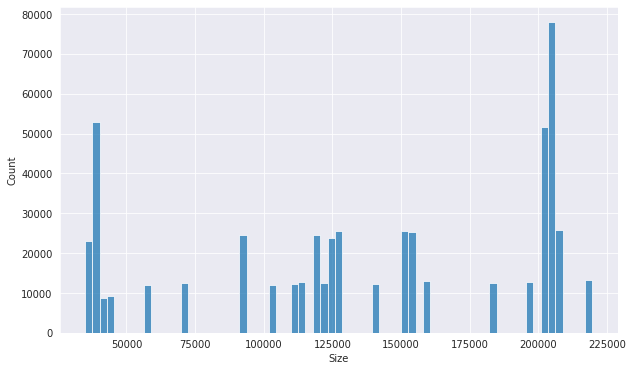

In [37]:
ax=plt.figure(figsize=(10,6))
sns.histplot(full_df.Size)

In [38]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aswanthjeje28/walmart-sales-prediction


'https://jovian.ai/aswanthjeje28/walmart-sales-prediction'

##Encoding

In [39]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536634 entries, 0 to 536633
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         536634 non-null  int64  
 1   Dept          536634 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     536634 non-null  bool   
 4   Temperature   536634 non-null  float64
 5   Fuel_Price    536634 non-null  float64
 6   CPI           536634 non-null  float64
 7   Unemployment  536634 non-null  float64
 8   Type          536634 non-null  object 
 9   Size          536634 non-null  int64  
 10  Day           536634 non-null  int64  
 11  Month         536634 non-null  int64  
 12  Year          536634 non-null  int64  
dtypes: bool(1), float64(5), int64(6), object(1)
memory usage: 49.6+ MB


In [40]:
full_df.loc[:,['IsHoliday']] = full_df.loc[:,['IsHoliday']].astype(int)
full_df.loc[:,'Type']= full_df.loc[:,'Type'].map({'A':3,'B':2,'C':1}) 

##Feature Engineering

#Modeling

Helper Function

In [41]:
def rmse(y_true,y_pred):
  return mean_squared_error(y_true,y_pred,squared=False)

In [42]:
def weighted_mean_squared_error(y_true,y_pred,is_holiday):
  weights = (is_holiday*4)+1
  return (weights * abs(y_true-y_pred))/weights.sum()


In [43]:
def test_tree_params(**params):
    model = DecisionTreeRegressor(random_state=42, **params).fit(train_inputs, train_targets)
    return rmse(train_targets,model.predict(train_inputs)), rmse(val_targets,model.predict(val_inputs))

In [44]:
def test_tree_param_and_plot(param_name,param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_tree_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])
    

In [45]:
train_df = full_df.copy()[:merge_train_df.shape[0]]
test_df = full_df.copy()[merge_train_df.shape[0]:]
features = [col for col in train_df.columns if col != target]
train_df,val_df = train_test_split(train_df,test_size=0.25,random_state=42)
train_inputs = train_df[features]
train_targets = train_df[target]
val_inputs = val_df[features]
val_targets = val_df[target]

## Decision Tree

In [46]:
tree = DecisionTreeRegressor()
tree.fit(train_inputs,train_targets)
train_preds = tree.predict(train_inputs)
val_preds = tree.predict(val_inputs)
base_acc = (rmse(train_targets,train_preds),rmse(val_targets,val_preds))

In [47]:
base_acc

(7.874126221045986e-17, 4548.545069020343)

In [48]:
test_tree_params(max_depth=14)

(4321.784848414918, 5317.328666668304)

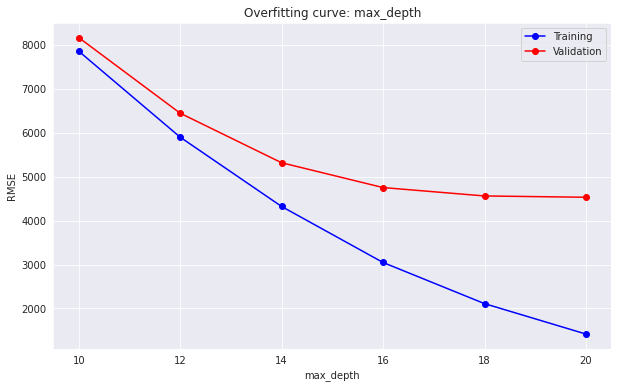

In [49]:
test_tree_param_and_plot('max_depth',[10,12,14,16,18,20])

In [50]:
pd.DataFrame({'feature':train_inputs.columns,'importances':tree.feature_importances_}).sort_values('importances',ascending =False)


,feature,importances
1,Dept,0.630419
8,Size,0.187470
0,Store,0.056879
10,Month,0.033318
5,CPI,0.026420
9,Day,0.020796
7,Type,0.016186
3,Temperature,0.010583
6,Unemployment,0.009685
4,Fuel_Price,0.004783


In [52]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aswanthjeje28/walmart-sales-prediction


'https://jovian.ai/aswanthjeje28/walmart-sales-prediction'